In [1]:
# Import depedencies
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MaxAbsScaler
from collections import Counter 
from imblearn.over_sampling import RandomOverSampler
from xgboost import XGBClassifier
from imblearn.metrics import classification_report_imbalanced
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

# Prepare the data

In [2]:
# Read the CSV data and create a new dataframe

df = pd.read_csv("Resources/match_team_data.csv")

In [3]:
# Create a column to account for Wins, Losses, and Ties
# Win = 1 , Loss = 0, Tie = -1

df["home_win"] = np.where(df["home_score"] > df["away_score"], 1, np.where(df["home_score"] == df["away_score"],0,-1))

In [4]:
# Remove NaNs
df2 = df.drop(columns=["team_2_post_season_result","team_1_post_season_result"])

In [5]:
# Check for NaNs
df2.isna().mean().sort_values(ascending=False).head(10)

winning_name                0.073937
winning_abbr                0.073937
losing_name                 0.073937
losing_abbr                 0.073937
away_score                  0.070223
home_score                  0.070223
boxscore                    0.000000
team_2_margin_of_victory    0.000000
team_2_pass_yards           0.000000
team_2_pass_touchdowns      0.000000
dtype: float64

In [6]:
# Remove NaNs

df3 = df2.dropna()

In [7]:
# Check for categorical data

df3.dtypes.sort_values().tail(15)

team_2_defensive_simple_rating_system    float64
team_1_points_contributed_by_offense     float64
away_name                                 object
away_abbr                                 object
home_name                                 object
home_abbr                                 object
team_2_abbreviation                       object
losing_name                               object
winning_abbr                              object
losing_abbr                               object
team_1_abbreviation                       object
team_2_name                               object
team_1_name                               object
winning_name                              object
boxscore                                  object
dtype: object

In [8]:
# Remove categorical data

df3.drop(columns=["away_name","away_abbr","home_name","home_abbr","team_2_abbreviation","losing_name","winning_abbr","losing_abbr","team_1_abbreviation","team_2_name","team_1_name","winning_name","boxscore","year","week","home_score","away_score"], inplace=True)

C:\Users\dariu\AppData\Local\Temp\ipykernel_16388\750371541.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3.drop(columns=["away_name","away_abbr","home_name","home_abbr","team_2_abbreviation","losing_name","winning_abbr","losing_abbr","team_1_abbreviation","team_2_name","team_1_name","winning_name","boxscore","year","week","home_score","away_score"], inplace=True)


# Random Forest Model

In [9]:
# Create target and features

y = df3["home_win"]
X = df3.drop(columns="home_win")

In [10]:
# Apply Train_Test_Split

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=1)

In [11]:
# Set the scaler
scaler = StandardScaler()

In [12]:
# Fit and Transform the data
X_scaler = scaler.fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [13]:
# Create the model
model = RandomForestClassifier()

In [14]:
# Fit the data
model.fit(X_train,y_train)

RandomForestClassifier()

In [15]:
# Make the predictions
y_pred = model.predict(X_test)

In [16]:
# print the results

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

[[142 169]
 [122 253]]
              precision    recall  f1-score   support

          -1       0.54      0.46      0.49       311
           1       0.60      0.67      0.63       375

    accuracy                           0.58       686
   macro avg       0.57      0.57      0.56       686
weighted avg       0.57      0.58      0.57       686

0.575801749271137


### Find feature importances

In [17]:
# Create list of model feature names

importances_names = model.feature_names_in_

In [18]:
# View importances of features in Random Forest Model

#importances = model.feature_importances_

importances=model.feature_importances_
indices = np.argsort(importances)[::-1]  # index value of a feature
names = [X_train.columns[i] for i in indices]  # extract the title of that feature

In [19]:
names[:10]

['team_1_penalties',
 'team_2_plays',
 'team_2_pass_first_downs',
 'team_1_yards_from_penalties',
 'team_1_points_against',
 'team_2_penalties',
 'team_2_rush_yards',
 'team_2_rank',
 'team_2_points_difference',
 'team_2_simple_rating_system']

In [20]:
# Create df that displays importances

importances_df = pd.DataFrame(importances,importances_names)

In [21]:
# Sort importances by values

importances_df.sort_values(ascending = False, by = [0]).tail(10)

,0
team_2_interceptions,0.008968
team_1_rush_touchdowns,0.008181
team_1_win_percentage,0.007909
team_2_win_percentage,0.007022
team_1_wins,0.006677
team_2_losses,0.006647
team_1_losses,0.006382
team_2_wins,0.005956
team_2_games_played,0.000000
team_1_games_played,0.000000


In [22]:
# drop the least important features
df4 = df3.drop(columns=["team_1_games_played","team_2_games_played","team_2_losses","team_1_wins","team_2_wins","team_1_losses"])

<AxesSubplot:>

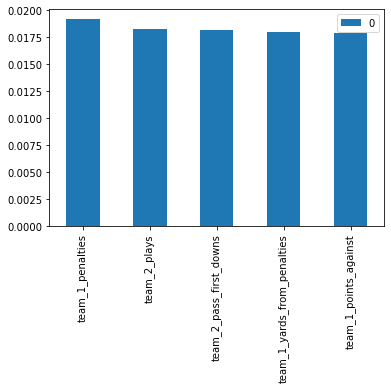

In [23]:
importances_df.sort_values(by = 0, ascending=False).head().plot(kind = "bar")

In [24]:
# View importances details

importances_df.describe()

,0
count,74.000000
mean,0.013514
std,0.003950
min,0.000000
25%,0.011830
50%,0.014544
75%,0.016326
max,0.019191


In [25]:
# Drop unimportant features and create new df

df4 = df3.drop(columns=["team_1_games_played","team_2_games_played","team_2_losses","team_1_wins","team_2_wins","team_1_losses"])

In [26]:
# Create new X and Y variables without dropped features

y = df4["home_win"]
X = df4.drop(columns="home_win")

In [27]:
# Create X and Y train and test sets

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=1)

In [28]:
# Scale X values

X_scaler = scaler.fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [29]:
# Fit model

model.fit(X_train,y_train)

RandomForestClassifier()

In [30]:
# Create y predictions

y_pred = model.predict(X_test)

In [31]:
# View model metrics

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

[[144 167]
 [133 242]]
              precision    recall  f1-score   support

          -1       0.52      0.46      0.49       311
           1       0.59      0.65      0.62       375

    accuracy                           0.56       686
   macro avg       0.56      0.55      0.55       686
weighted avg       0.56      0.56      0.56       686

0.5626822157434402


### Tune the scaler

In [32]:
# Set scaler

scaler = MinMaxScaler()

In [33]:
# Fit X data to scaler

X_scaler = scaler.fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [34]:
# Fit model

model.fit(X_train,y_train)

RandomForestClassifier()

In [35]:
# Create y predictions

y_pred = model.predict(X_test)

In [36]:
# View model metrics

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

[[141 170]
 [132 243]]
              precision    recall  f1-score   support

          -1       0.52      0.45      0.48       311
           1       0.59      0.65      0.62       375

    accuracy                           0.56       686
   macro avg       0.55      0.55      0.55       686
weighted avg       0.56      0.56      0.56       686

0.5597667638483965


In [37]:
# Try robust scaler

scaler = RobustScaler()

In [38]:
# Scale X data

X_scaler = scaler.fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [39]:
# Fit model

model.fit(X_train,y_train)

RandomForestClassifier()

In [40]:
# Set y predictions 

y_pred = model.predict(X_test)

In [41]:
# View model metrics

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

[[147 164]
 [140 235]]
              precision    recall  f1-score   support

          -1       0.51      0.47      0.49       311
           1       0.59      0.63      0.61       375

    accuracy                           0.56       686
   macro avg       0.55      0.55      0.55       686
weighted avg       0.55      0.56      0.55       686

0.5568513119533528


In [42]:
# Try MaxAbsScaler

scaler = MaxAbsScaler()

In [43]:
# Scale X data

X_scaler = scaler.fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [44]:
# Fit model

model.fit(X_train,y_train)

RandomForestClassifier()

In [45]:
# Set y predictions

y_pred = model.predict(X_test)

In [46]:
# View model metrics

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

[[148 163]
 [138 237]]
              precision    recall  f1-score   support

          -1       0.52      0.48      0.50       311
           1       0.59      0.63      0.61       375

    accuracy                           0.56       686
   macro avg       0.55      0.55      0.55       686
weighted avg       0.56      0.56      0.56       686

0.5612244897959183


### Tune the train_test_split

In [47]:
# Split X and Y data

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=1, test_size=.3)

In [48]:
# Scale X data

X_scaler = scaler.fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [49]:
# Fit model

model.fit(X_train,y_train)

RandomForestClassifier()

In [50]:
# Set y predictions

y_pred = model.predict(X_test)

In [51]:
# View model metrics

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

[[177 194]
 [172 280]]
              precision    recall  f1-score   support

          -1       0.51      0.48      0.49       371
           1       0.59      0.62      0.60       452

    accuracy                           0.56       823
   macro avg       0.55      0.55      0.55       823
weighted avg       0.55      0.56      0.55       823

0.5552855407047388


### Tune imbalancedness

In [52]:
# Use Counter to test training data for imbalancedness

Counter(y_train)

Counter({-1: 844, 1: 1076})

In [53]:
# Set model

ros = RandomOverSampler(random_state=1)

In [54]:
# Fit model sampler

X_train_oversampled,y_train_oversampled = ros.fit_resample(X_train, y_train) 

In [55]:
# Fit model

model.fit(X_train_oversampled,y_train_oversampled)

RandomForestClassifier()

In [56]:
# Make predictions

y_pred = model.predict(X_test)

In [57]:
# View model metrics

print(confusion_matrix(y_test,y_pred))
print(classification_report_imbalanced(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

[[194 177]
 [189 263]]
                   pre       rec       spe        f1       geo       iba       sup

         -1       0.51      0.52      0.58      0.51      0.55      0.30       371
          1       0.60      0.58      0.52      0.59      0.55      0.31       452

avg / total       0.56      0.56      0.55      0.56      0.55      0.30       823

0.5552855407047388


# xgBoost Model

### Prepare the data

In [58]:
# Create a new df for the model to adjust for the binary target

df5 = pd.read_csv("Resources/match_team_data.csv")

In [59]:
# Create a column to account for Wins, Losses, and Ties

df5["home_win"] = np.where(df["home_score"] > df["away_score"], 1,0)

In [60]:
# Remove NaNs

df5 = df5.drop(columns=["team_2_post_season_result","team_1_post_season_result"])

In [61]:
df6 = df5.dropna()

In [62]:
# Remove categorical data

df6.drop(columns=["away_name","away_abbr","home_name","home_abbr","team_2_abbreviation","losing_name","winning_abbr","losing_abbr","team_1_abbreviation","team_2_name","team_1_name","winning_name","boxscore","year","week","home_score","away_score"], inplace=True)

C:\Users\dariu\AppData\Local\Temp\ipykernel_16388\4186728455.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df6.drop(columns=["away_name","away_abbr","home_name","home_abbr","team_2_abbreviation","losing_name","winning_abbr","losing_abbr","team_1_abbreviation","team_2_name","team_1_name","winning_name","boxscore","year","week","home_score","away_score"], inplace=True)


In [63]:
# Create target and features

y = df6["home_win"]
X = df6.drop(columns="home_win")

In [64]:
# Apply Train_Test_Split

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=1)

In [65]:
# Set the scaler

scaler = StandardScaler()

In [66]:
# Fit and Transform the data

X_scaler = scaler.fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [67]:
# Create the XGB model

model = XGBClassifier()

In [68]:
# Fit the data

model.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [69]:
# Make the predictions

y_pred = model.predict(X_test)

In [70]:
# print the results

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

[[150 161]
 [137 238]]
              precision    recall  f1-score   support

           0       0.52      0.48      0.50       311
           1       0.60      0.63      0.61       375

    accuracy                           0.57       686
   macro avg       0.56      0.56      0.56       686
weighted avg       0.56      0.57      0.56       686

0.565597667638484


### Tune imbalancedness

In [71]:
# Use Counter to test training data for imbalancedness

Counter(y_train)

Counter({1: 1153, 0: 904})

In [72]:
# Fit model sampler

X_train_oversampled,y_train_oversampled = ros.fit_resample(X_train, y_train) 

In [73]:
# Fit model

model.fit(X_train_oversampled,y_train_oversampled)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [74]:
# Make predictions

y_pred = model.predict(X_test)

In [75]:
# View model metrics

print(confusion_matrix(y_test,y_pred))
print(classification_report_imbalanced(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

[[156 155]
 [155 220]]
                   pre       rec       spe        f1       geo       iba       sup

          0       0.50      0.50      0.59      0.50      0.54      0.29       311
          1       0.59      0.59      0.50      0.59      0.54      0.30       375

avg / total       0.55      0.55      0.54      0.55      0.54      0.29       686

0.5481049562682215


# TensorFlow Sequential

In [76]:
# Create the model

nn = Sequential()
number_input_features = len(X_train.iloc[0])
number_output_neurons = 1
hidden_nodes_layer1 =  (number_input_features + number_output_neurons)//2
hidden_nodes_layer2 =  (hidden_nodes_layer1 + number_output_neurons)//2

In [77]:
# Fit the data

nn.add(Dense(units= hidden_nodes_layer1, input_dim=number_input_features, activation="relu"))
nn.add(Dense(units= hidden_nodes_layer2, activation="relu"))
nn.add(Dense(units=number_output_neurons, activation="sigmoid"))

In [78]:
nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 37)                2775      
                                                                 
 dense_1 (Dense)             (None, 19)                722       
                                                                 
 dense_2 (Dense)             (None, 1)                 20        
                                                                 
Total params: 3,517
Trainable params: 3,517
Non-trainable params: 0
_________________________________________________________________


In [79]:
nn.compile(loss = "binary_crossentropy", optimizer =  "adam", metrics = ["accuracy"])
nn_fitted = nn.fit(X_train_scaled, y_train, epochs = 50)

Epoch 1/50
65/65 [==============================] - 0s 1ms/step - loss: 0.7065 - accuracy: 0.5357
Epoch 2/50
65/65 [==============================] - 0s 1ms/step - loss: 0.6679 - accuracy: 0.5868
Epoch 3/50
65/65 [==============================] - 0s 1ms/step - loss: 0.6526 - accuracy: 0.6213
Epoch 4/50
65/65 [==============================] - 0s 1ms/step - loss: 0.6443 - accuracy: 0.6373
Epoch 5/50
65/65 [==============================] - 0s 1ms/step - loss: 0.6388 - accuracy: 0.6500
Epoch 6/50
65/65 [==============================] - 0s 1ms/step - loss: 0.6308 - accuracy: 0.6539
Epoch 7/50
65/65 [==============================] - 0s 1ms/step - loss: 0.6255 - accuracy: 0.6544
Epoch 8/50
65/65 [==============================] - 0s 1ms/step - loss: 0.6222 - accuracy: 0.6665
Epoch 9/50
65/65 [==============================] - 0s 1ms/step - loss: 0.6167 - accuracy: 0.6684
Epoch 10/50
65/65 [==============================] - 0s 1ms/step - loss: 0.6118 - accuracy: 0.6694
Epoch 11/50
65/65 [

In [80]:
model_loss, model_accuracy = nn.evaluate(X_test_scaled, y_test, verbose = 2)

22/22 - 0s - loss: 0.7754 - accuracy: 0.5598 - 123ms/epoch - 6ms/step


In [81]:
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

Loss: 0.7753816246986389, Accuracy: 0.5597667694091797


### Sequnetial model with Nadam optimizer

In [82]:
# Create the model

nn = Sequential()
number_input_features = len(X_train.iloc[0])
number_output_neurons = 1
hidden_nodes_layer1 =  (number_input_features + number_output_neurons)//2
hidden_nodes_layer2 =  (hidden_nodes_layer1 + number_output_neurons)//2

In [83]:
# Fit the data

nn.add(Dense(units= hidden_nodes_layer1, input_dim=number_input_features, activation="relu"))
nn.add(Dense(units= hidden_nodes_layer2, activation="relu"))
nn.add(Dense(units=number_output_neurons, activation="sigmoid"))

In [84]:
nn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 37)                2775      
                                                                 
 dense_4 (Dense)             (None, 19)                722       
                                                                 
 dense_5 (Dense)             (None, 1)                 20        
                                                                 
Total params: 3,517
Trainable params: 3,517
Non-trainable params: 0
_________________________________________________________________


In [85]:
nn.compile(loss = "binary_crossentropy", optimizer =  "Nadam", metrics = ["accuracy"])
nn_fitted = nn.fit(X_train_scaled, y_train, epochs = 50)

Epoch 1/50
65/65 [==============================] - 1s 1ms/step - loss: 0.7012 - accuracy: 0.5391
Epoch 2/50
65/65 [==============================] - 0s 1ms/step - loss: 0.6721 - accuracy: 0.5858
Epoch 3/50
65/65 [==============================] - 0s 1ms/step - loss: 0.6598 - accuracy: 0.6053
Epoch 4/50
65/65 [==============================] - 0s 1ms/step - loss: 0.6508 - accuracy: 0.6218
Epoch 5/50
65/65 [==============================] - 0s 1ms/step - loss: 0.6416 - accuracy: 0.6339
Epoch 6/50
65/65 [==============================] - 0s 1ms/step - loss: 0.6348 - accuracy: 0.6461
Epoch 7/50
65/65 [==============================] - 0s 1ms/step - loss: 0.6288 - accuracy: 0.6509
Epoch 8/50
65/65 [==============================] - 0s 1ms/step - loss: 0.6241 - accuracy: 0.6529
Epoch 9/50
65/65 [==============================] - 0s 1ms/step - loss: 0.6186 - accuracy: 0.6558
Epoch 10/50
65/65 [==============================] - 0s 1ms/step - loss: 0.6143 - accuracy: 0.6626
Epoch 11/50
65/65 [

In [86]:
model_loss, model_accuracy = nn.evaluate(X_test_scaled, y_test, verbose = 2)

22/22 - 0s - loss: 0.8001 - accuracy: 0.5598 - 123ms/epoch - 6ms/step


In [87]:
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

Loss: 0.8000973463058472, Accuracy: 0.5597667694091797
